In [1]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.1+cu101


# 0. load data

In [2]:
input_fn = 'F:\\Github\\kaggle drought\\data_ndarray.npz'

In [3]:
data = np.load(open(input_fn, 'rb'))

In [4]:
X_train = data['X_train']

In [5]:
X_train.shape

(118024, 90, 18)

In [6]:
print(np.mean(X_train.flatten()))

1.1619668e-07


In [7]:
print(np.std(X_train.flatten()))

1.0000005


In [8]:
X_valid = data['X_valid']

In [9]:
X_test = data['X_test']

In [10]:
y_train = data['y_train']
y_train = np.array([int(i) for i in y_train])

In [11]:
y_valid = data['y_valid']
y_valid = np.array([int(i) for i in y_valid])

In [12]:
y_test = data['y_test']
y_test = np.array([int(i) for i in y_test])

We need to exchange two axes：
* **number of samples**
* **number of features** (aka variables, dimensions, channels)
* **number of steps** (or length, time steps, sequence steps)

In [13]:
X_train = X_train.transpose(0, 2, 1)
X_train.shape

(118024, 18, 90)

In [14]:
X_valid = X_valid.transpose(0, 2, 1)
X_valid.shape

(20721, 18, 90)

In [15]:
X_test = X_test.transpose(0, 2, 1)
X_test.shape

(102430, 18, 90)

We already have the split:

In [16]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [17]:
X.shape

(138745, 18, 90)

In [18]:
y.shape

(138745,)

In [19]:
splits

((#118024) [0,1,2,3,4,5,6,7,8,9...],
 (#20721) [118024,118025,118026,118027,118028,118029,118030,118031,118032,118033...])

In [20]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#138745) [(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32))...]

# 1. Model and Hyperparameter Tuning

In [21]:
import hyperopt
print(hyperopt.__version__)

0.2.5


In [22]:
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp

In [23]:
search_space = {
    'batch_size': hp.choice('bs', [256, 512, 1024]),
    'time_steps': hp.choice('ts', [30, 60, 90]),  # lookback window size
    "lr": hp.choice('lr', [0.1, 0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [10, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    # model parameters
    "layers": hp.choice('layers', [[25, 25, 25, 25, 25, 25, 25, 25], [25, 25, 25, 25, 25, 25], [25, 25, 25, 25]]),
    "ks": hp.choice('ks', [7, 5, 3]),
    "conv_dropout": hp.choice('conv_dropout', [0.0, 0.1, 0.2, 0.5])
}

In [24]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x223c988ae88>,
 'time_steps': <hyperopt.pyll.base.Apply at 0x223c988d508>,
 'lr': <hyperopt.pyll.base.Apply at 0x223c988dac8>,
 'epochs': <hyperopt.pyll.base.Apply at 0x223c9887108>,
 'patience': <hyperopt.pyll.base.Apply at 0x223c9887688>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x223c9887c88>,
 'layers': <hyperopt.pyll.base.Apply at 0x223c9876208>,
 'ks': <hyperopt.pyll.base.Apply at 0x223c9876748>,
 'conv_dropout': <hyperopt.pyll.base.Apply at 0x223c9876e88>}

In [25]:
X.shape

(138745, 18, 90)

In [26]:
time_steps = 30

In [27]:
X[:, :, -time_steps:].shape

(138745, 18, 30)

In [28]:
X_test[:, :, -time_steps:].shape

(102430, 18, 30)

In [29]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [30]:
import time
from fastai.callback.tracker import EarlyStoppingCallback

In [31]:
import gc

In [32]:
# clear memory 
gc.collect()

183

In [33]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:",params)
        batch_size = params["batch_size"]
        time_steps = params["time_steps"]
    
        # Create data loader
        tfms  = [None, [Categorize()]]
        dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = TCN
        k = {
            'layers': params['layers'],
            'ks': params['ks'],
            'conv_dropout': params['conv_dropout']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
    
        # Training the model
        learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
    
        vals = learn.recorder.values[-1]
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Search the parameters:

Trying params:                                                                                                         
{'batch_size': 1024, 'conv_dropout': 0.1, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function SGD at 0x000002238948E0D8>, 'patience': 10, 'time_steps': 30}
TCN                                                                                                                    
  0%|                                                                           | 0/30 [00:27<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,1.603173,1.577761,0.664543,00:03
1,1.534471,1.495298,0.664543,00:02
2,1.450770,1.398901,0.664543,00:02
3,1.353798,1.296561,0.664543,00:02
4,1.267546,1.215593,0.664543,00:02
5,1.214750,1.171125,0.664543,00:02
6,1.180002,1.146712,0.664543,00:02
7,1.158941,1.130025,0.664543,00:02
8,1.133401,1.116845,0.664543,00:02
9,1.111820,1.106265,0.664543,00:02


No improvement since epoch 77: early stopping                                                                          
  0%|                                                                           | 0/30 [03:40<?, ?trial/s, best loss=?]

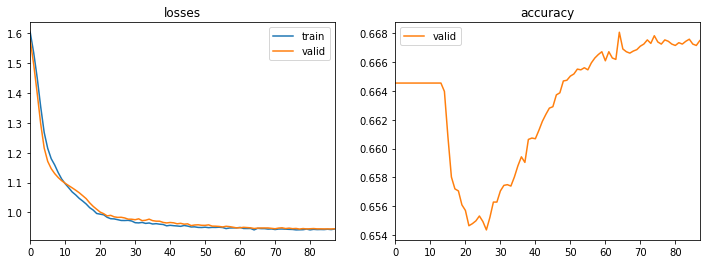

Trying params:                                                                                                         
{'batch_size': 256, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function RMSProp at 0x000002238948E1F8>, 'patience': 10, 'time_steps': 60}
TCN                                                                                                                    
  3%|█▌                                            | 1/30 [04:07<1:46:54, 221.18s/trial, best loss: 0.9452560544013977]

epoch,train_loss,valid_loss,accuracy,time
0,0.932935,0.931089,0.666908,00:10
1,0.919317,0.888632,0.673278,00:09
2,0.900004,0.865815,0.683799,00:09
3,0.880764,0.827978,0.689735,00:09
4,0.887001,0.851269,0.683413,00:09
5,0.875376,0.847204,0.684668,00:09
6,0.876428,0.880746,0.680373,00:09
7,0.865960,0.886800,0.674871,00:09
8,0.852389,0.868970,0.678394,00:10
9,0.853539,0.891920,0.677622,00:09


No improvement since epoch 3: early stopping                                                                           
  3%|█▌                                            | 1/30 [06:27<1:46:54, 221.18s/trial, best loss: 0.9452560544013977]

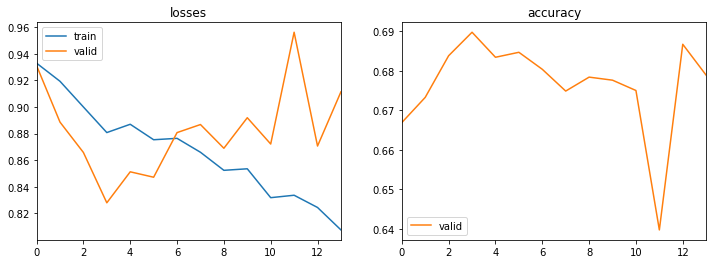

Trying params:                                                                                                         
{'batch_size': 256, 'conv_dropout': 0.1, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function SGD at 0x000002238948E0D8>, 'patience': 10, 'time_steps': 60}
TCN                                                                                                                    
  7%|███                                           | 2/30 [06:53<1:35:30, 204.66s/trial, best loss: 0.9113789796829224]

epoch,train_loss,valid_loss,accuracy,time
0,1.881043,1.880900,0.031852,00:05
1,1.875558,1.875631,0.032334,00:05
2,1.869550,1.866348,0.033396,00:05
3,1.855214,1.851455,0.039815,00:05
4,1.834577,1.829797,0.051735,00:05
5,1.806965,1.800717,0.078326,00:05
6,1.771653,1.763948,0.105400,00:05
7,1.730379,1.719491,0.162058,00:05
8,1.680159,1.667554,0.438203,00:05
9,1.622305,1.608477,0.606341,00:05


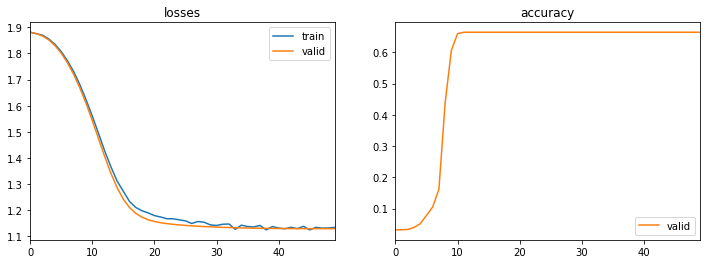

Trying params:                                                                                                         
{'batch_size': 512, 'conv_dropout': 0.1, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x000002238948E1F8>, 'patience': 5, 'time_steps': 30}
TCN                                                                                                                    
 10%|████▌                                         | 3/30 [11:51<1:44:40, 232.60s/trial, best loss: 0.9113789796829224]

epoch,train_loss,valid_loss,accuracy,time
0,1.802213,1.786469,0.166353,00:03
1,1.736670,1.714562,0.252787,00:03
2,1.641940,1.606064,0.440278,00:03
3,1.485384,1.431094,0.660248,00:03
4,1.288227,1.226736,0.664543,00:03
5,1.174705,1.151183,0.664543,00:03
6,1.107502,1.116534,0.664543,00:03
7,1.066968,1.092122,0.663964,00:03
8,1.048101,1.060425,0.661889,00:03
9,1.018919,1.021633,0.657546,00:03


No improvement since epoch 36: early stopping                                                                          
 10%|████▌                                         | 3/30 [14:09<1:44:40, 232.60s/trial, best loss: 0.9113789796829224]

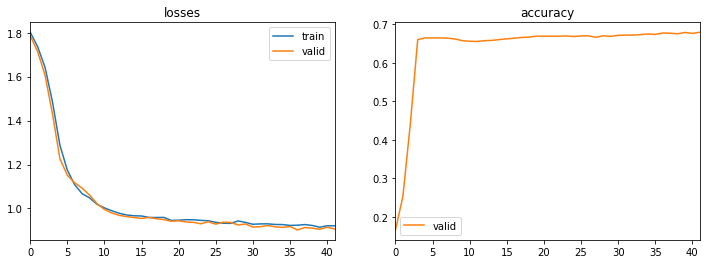

Trying params:                                                                                                         
{'batch_size': 1024, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function SGD at 0x000002238948E0D8>, 'patience': 5, 'time_steps': 60}
TCN                                                                                                                    
 13%|██████▏                                       | 4/30 [14:35<1:31:56, 212.17s/trial, best loss: 0.9065491557121277]

epoch,train_loss,valid_loss,accuracy,time
0,1.978111,1.989813,0.077168,00:02
1,1.961770,1.967747,0.076251,00:02
2,1.932638,1.930138,0.072969,00:02
3,1.885483,1.872339,0.066454,00:02
4,1.818129,1.792013,0.142416,00:02
5,1.728125,1.687153,0.297476,00:02
6,1.615324,1.555803,0.664157,00:02
7,1.480219,1.406513,0.664543,00:02
8,1.348436,1.275593,0.664543,00:02
9,1.253421,1.197721,0.664543,00:02


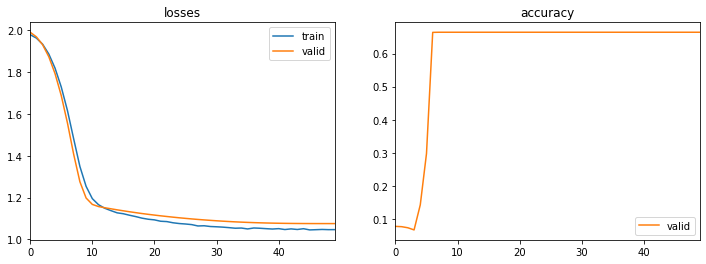

Trying params:                                                                                                         
{'batch_size': 512, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 10, 'time_steps': 90}
TCN                                                                                                                    
 17%|███████▋                                      | 5/30 [16:48<1:18:29, 188.38s/trial, best loss: 0.9065491557121277]

epoch,train_loss,valid_loss,accuracy,time
0,1.779757,1.770188,0.239660,00:04
1,1.730521,1.716478,0.658221,00:03
2,1.651352,1.624699,0.664543,00:03
3,1.489205,1.433725,0.664543,00:03
4,1.201509,1.160101,0.664543,00:03
5,1.112337,1.118952,0.664543,00:03
6,1.078074,1.098068,0.664543,00:03
7,1.041336,1.061990,0.664543,00:03
8,1.004256,1.006334,0.661937,00:03
9,0.981275,0.973910,0.655567,00:03


No improvement since epoch 49: early stopping                                                                          
 17%|███████▋                                      | 5/30 [20:42<1:18:29, 188.38s/trial, best loss: 0.9065491557121277]

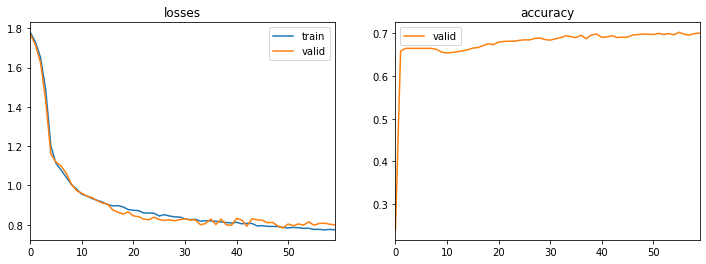

Trying params:                                                                                                         
{'batch_size': 1024, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x000002238948E1F8>, 'patience': 10, 'time_steps': 90}
TCN                                                                                                                    
 20%|█████████▏                                    | 6/30 [21:09<1:23:58, 209.93s/trial, best loss: 0.7997812628746033]

epoch,train_loss,valid_loss,accuracy,time
0,1.769043,1.740316,0.241301,00:02
1,1.733028,1.702701,0.650982,00:02
2,1.683612,1.645699,0.664543,00:02
3,1.599266,1.540452,0.664543,00:02
4,1.443230,1.353290,0.664543,00:02
5,1.269937,1.201667,0.664543,00:02
6,1.168157,1.139242,0.664543,00:02
7,1.114416,1.118489,0.664543,00:02
8,1.078368,1.102039,0.664543,00:02
9,1.049236,1.067148,0.664543,00:02


No improvement since epoch 73: early stopping                                                                          
 20%|█████████▏                                    | 6/30 [24:53<1:23:58, 209.93s/trial, best loss: 0.7997812628746033]

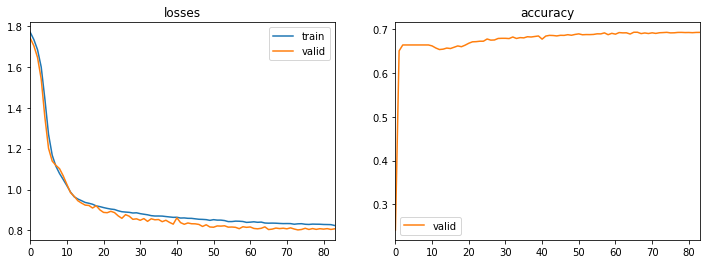

Trying params:                                                                                                         
{'batch_size': 256, 'conv_dropout': 0.0, 'epochs': 10, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function RMSProp at 0x000002238948E1F8>, 'patience': 10, 'time_steps': 90}
TCN                                                                                                                    
 23%|██████████▋                                   | 7/30 [25:20<1:25:12, 222.30s/trial, best loss: 0.7997812628746033]

epoch,train_loss,valid_loss,accuracy,time
0,0.945078,0.937702,0.661889,00:10
1,0.920003,0.862375,0.679938,00:10
2,0.890141,0.814132,0.689687,00:10
3,0.845710,0.853840,0.683992,00:10
4,0.817902,0.852555,0.684378,00:10
5,0.782901,0.821932,0.687660,00:10
6,0.740137,0.862441,0.676222,00:10
7,0.690209,0.894279,0.686743,00:10
8,0.675786,0.906429,0.687756,00:10
9,0.670777,0.914004,0.688335,00:10


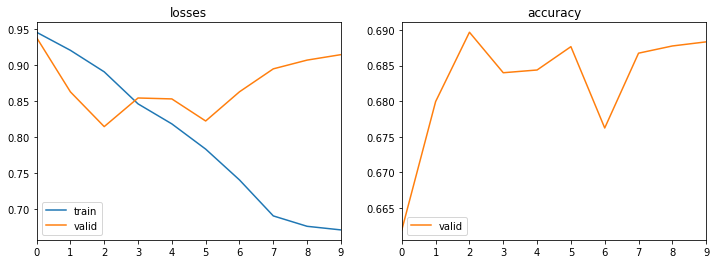

Trying params:                                                                                                         
{'batch_size': 512, 'conv_dropout': 0.1, 'epochs': 10, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function RMSProp at 0x000002238948E1F8>, 'patience': 5, 'time_steps': 90}
TCN                                                                                                                    
 27%|████████████▎                                 | 8/30 [27:27<1:11:03, 193.80s/trial, best loss: 0.7997812628746033]

epoch,train_loss,valid_loss,accuracy,time
0,0.967072,0.973973,0.669466,00:06
1,0.939148,0.968463,0.658318,00:06
2,0.912466,0.841181,0.682351,00:06
3,0.883103,0.929036,0.669273,00:06
4,0.860305,0.833291,0.695961,00:06
5,0.829245,0.816542,0.689108,00:06
6,0.808964,0.810356,0.694175,00:06
7,0.772383,0.819309,0.691955,00:06
8,0.751295,0.832864,0.689832,00:06
9,0.748300,0.832914,0.690073,00:06


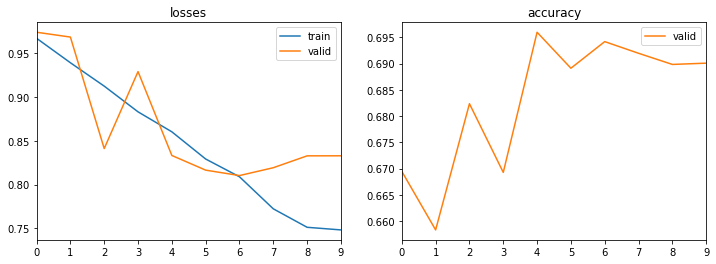

Trying params:                                                                                                         
{'batch_size': 256, 'conv_dropout': 0.0, 'epochs': 100, 'ks': 5, 'layers': (25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 5, 'time_steps': 90}
TCN                                                                                                                    
 30%|██████████████▍                                 | 9/30 [28:57<57:05, 163.12s/trial, best loss: 0.7997812628746033]

epoch,train_loss,valid_loss,accuracy,time
0,0.935075,0.917006,0.651899,00:06
1,0.890765,0.865877,0.672796,00:06
2,0.862952,0.829530,0.691135,00:07
3,0.847764,0.853154,0.680131,00:06
4,0.844467,0.785139,0.698905,00:07
5,0.814236,0.827626,0.686164,00:07
6,0.814781,0.832550,0.689832,00:06
7,0.796903,0.824732,0.692196,00:06
8,0.776701,0.851847,0.686212,00:06
9,0.782468,0.832493,0.691955,00:06


No improvement since epoch 4: early stopping                                                                           
 30%|██████████████▍                                 | 9/30 [30:07<57:05, 163.12s/trial, best loss: 0.7997812628746033]

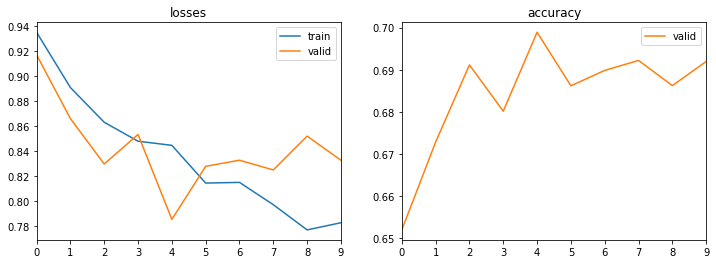

Trying params:                                                                                                         
{'batch_size': 512, 'conv_dropout': 0.5, 'epochs': 50, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function RMSProp at 0x000002238948E1F8>, 'patience': 10, 'time_steps': 30}
TCN                                                                                                                    
 33%|███████████████▋                               | 10/30 [30:33<47:33, 142.70s/trial, best loss: 0.7997812628746033]

epoch,train_loss,valid_loss,accuracy,time
0,0.980547,0.983894,0.671348,00:03
1,0.968709,0.930708,0.674581,00:03
2,0.956872,0.947300,0.670721,00:03
3,0.969391,0.943223,0.667825,00:03
4,0.972778,0.962780,0.667101,00:03
5,0.975472,0.954343,0.664157,00:03
6,0.990671,0.949760,0.673375,00:03
7,0.983163,0.954800,0.672265,00:03
8,0.995493,0.993135,0.664061,00:03
9,1.142509,0.977921,0.667632,00:03


No improvement since epoch 10: early stopping                                                                          
 33%|███████████████▋                               | 10/30 [31:43<47:33, 142.70s/trial, best loss: 0.7997812628746033]

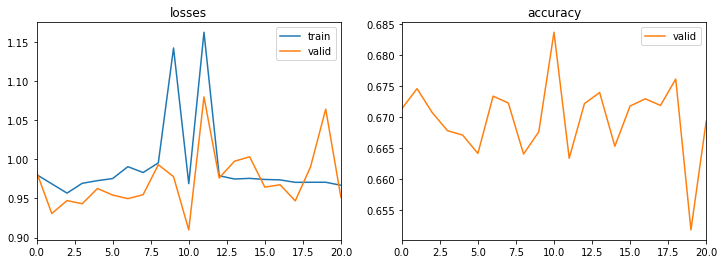

Trying params:                                                                                                         
{'batch_size': 1024, 'conv_dropout': 0.2, 'epochs': 10, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function RMSProp at 0x000002238948E1F8>, 'patience': 10, 'time_steps': 90}
TCN                                                                                                                    
 37%|█████████████████▏                             | 11/30 [32:09<40:42, 128.57s/trial, best loss: 0.7997812628746033]

epoch,train_loss,valid_loss,accuracy,time
0,1.315974,1.069910,0.655326,00:04
1,1.033127,1.021452,0.637855,00:04
2,0.997309,0.995548,0.647990,00:04
3,0.965569,0.925724,0.661937,00:04
4,1.004968,0.935690,0.663047,00:04
5,0.947182,0.939243,0.657594,00:04
6,0.928416,0.893376,0.674002,00:04
7,0.905854,0.872701,0.679986,00:04
8,0.893740,0.834171,0.688529,00:04
9,0.884930,0.845709,0.685923,00:04


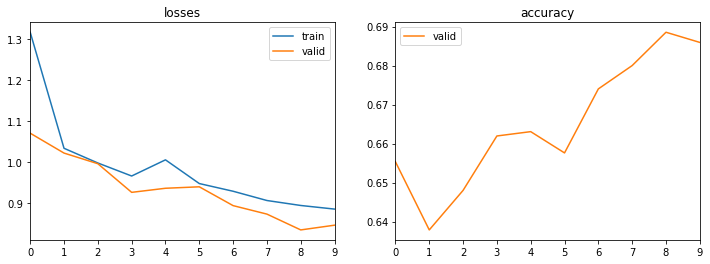

Trying params:                                                                                                         
{'batch_size': 256, 'conv_dropout': 0.0, 'epochs': 10, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function RMSProp at 0x000002238948E1F8>, 'patience': 5, 'time_steps': 30}
TCN                                                                                                                    
 40%|██████████████████▊                            | 12/30 [33:18<33:13, 110.77s/trial, best loss: 0.7997812628746033]

epoch,train_loss,valid_loss,accuracy,time
0,0.991007,0.972377,0.658462,00:07
1,1.012912,0.980219,0.667294,00:07
2,1.049721,0.999723,0.662323,00:07
3,0.999189,1.014571,0.670527,00:07
4,0.973390,0.961055,0.667535,00:07
5,0.977763,0.975990,0.664447,00:07
6,0.961580,0.965890,0.664978,00:07
7,0.956017,0.940930,0.672844,00:07
8,0.939401,0.950146,0.670045,00:07
9,0.936039,0.955527,0.669948,00:07


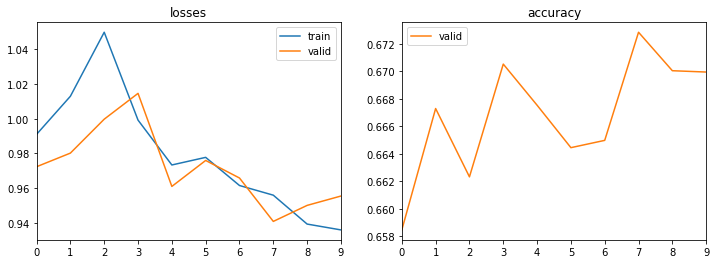

Trying params:                                                                                                         
{'batch_size': 256, 'conv_dropout': 0.5, 'epochs': 10, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.01, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 10, 'time_steps': 60}
TCN                                                                                                                    
 43%|████████████████████▎                          | 13/30 [35:01<30:45, 108.54s/trial, best loss: 0.7997812628746033]

epoch,train_loss,valid_loss,accuracy,time
0,0.939382,0.923938,0.671927,00:09
1,0.904081,0.893781,0.677043,00:09
2,0.896189,0.893090,0.669080,00:09
3,0.862768,0.849077,0.682062,00:09
4,0.851445,0.824889,0.688384,00:09
5,0.830489,0.877687,0.673278,00:09
6,0.826954,0.852296,0.682930,00:09
7,0.807125,0.849741,0.681241,00:09
8,0.798257,0.844072,0.686357,00:09
9,0.794949,0.852207,0.683558,00:09


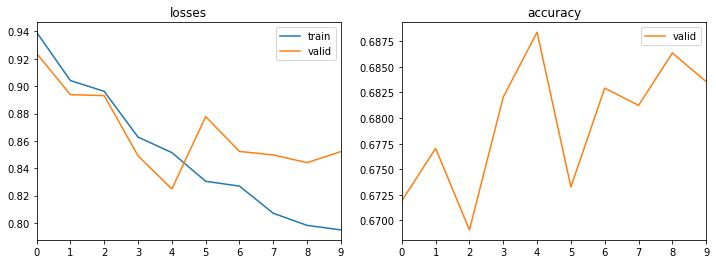

Trying params:                                                                                                         
{'batch_size': 1024, 'conv_dropout': 0.2, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x000002238948E1F8>, 'patience': 5, 'time_steps': 90}
TCN                                                                                                                    
 47%|█████████████████████▉                         | 14/30 [37:03<29:57, 112.32s/trial, best loss: 0.7997812628746033]

epoch,train_loss,valid_loss,accuracy,time
0,2.067288,2.017164,0.037595,00:06
1,2.002174,1.946918,0.037450,00:05
2,1.904392,1.829249,0.039911,00:05
3,1.691374,1.534678,0.661455,00:05
4,1.326124,1.204937,0.664543,00:05
5,1.169026,1.125711,0.664543,00:05
6,1.082206,1.075940,0.664543,00:05
7,1.025056,1.023899,0.658607,00:05
8,0.984464,0.957729,0.659862,00:05
9,0.957436,0.942636,0.656291,00:05


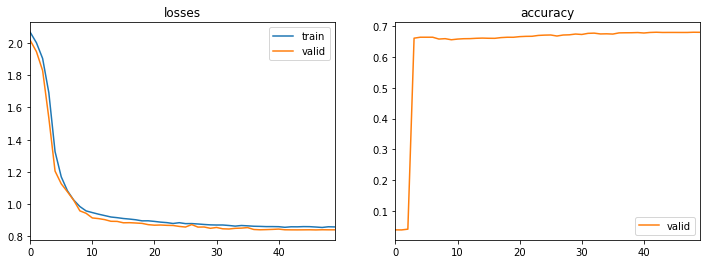

Trying params:                                                                                                         
{'batch_size': 512, 'conv_dropout': 0.1, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 5, 'time_steps': 90}
TCN                                                                                                                    
 50%|███████████████████████▌                       | 15/30 [42:11<42:43, 170.92s/trial, best loss: 0.7997812628746033]

epoch,train_loss,valid_loss,accuracy,time
0,1.273193,1.161886,0.664543,00:05
1,1.093899,1.093260,0.664543,00:05
2,1.024730,1.043463,0.664495,00:05
3,0.968174,0.963757,0.656677,00:04
4,0.939007,0.939005,0.661406,00:05
5,0.920720,0.933802,0.660924,00:04
6,0.908493,0.920237,0.667632,00:04
7,0.897304,0.941573,0.654746,00:05
8,0.888075,0.878956,0.679118,00:04
9,0.886393,0.904934,0.667728,00:04


No improvement since epoch 14: early stopping                                                                          
 50%|███████████████████████▌                       | 15/30 [43:53<42:43, 170.92s/trial, best loss: 0.7997812628746033]

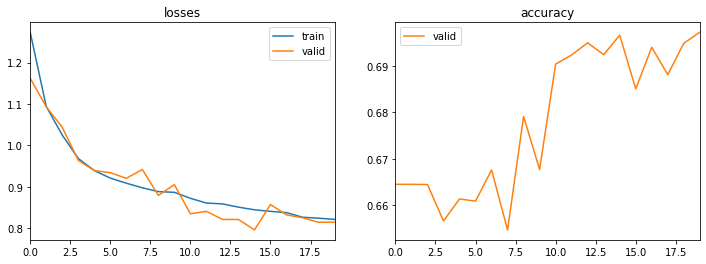

Trying params:                                                                                                         
{'batch_size': 512, 'conv_dropout': 0.2, 'epochs': 10, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function SGD at 0x000002238948E0D8>, 'patience': 10, 'time_steps': 90}
TCN                                                                                                                    
 53%|█████████████████████████                      | 16/30 [44:22<36:59, 158.52s/trial, best loss: 0.7997812628746033]

epoch,train_loss,valid_loss,accuracy,time
0,1.786720,1.770465,0.031417,00:03
1,1.773040,1.756787,0.031417,00:03
2,1.755962,1.736757,0.031417,00:03
3,1.736097,1.717707,0.034747,00:03
4,1.717831,1.701361,0.299406,00:03
5,1.704995,1.688685,0.557840,00:03
6,1.695851,1.680065,0.603349,00:03
7,1.690258,1.675240,0.614208,00:03
8,1.685708,1.673363,0.616573,00:03
9,1.686050,1.673086,0.616910,00:03


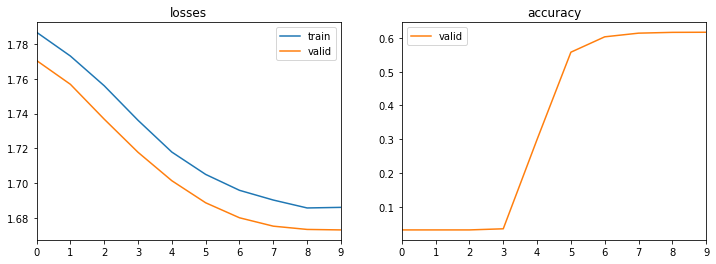

Trying params:                                                                                                         
{'batch_size': 256, 'conv_dropout': 0.0, 'epochs': 50, 'ks': 5, 'layers': (25, 25, 25, 25, 25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function SGD at 0x000002238948E0D8>, 'patience': 10, 'time_steps': 30}
TCN                                                                                                                    
 57%|██████████████████████████▋                    | 17/30 [45:20<27:52, 128.69s/trial, best loss: 0.7997812628746033]

epoch,train_loss,valid_loss,accuracy,time
0,1.617101,1.596506,0.613580,00:08
1,1.579058,1.553687,0.659572,00:08
2,1.511668,1.482796,0.664543,00:08
3,1.425165,1.382328,0.664543,00:08
4,1.314511,1.270740,0.664543,00:08
5,1.233502,1.186235,0.664543,00:08
6,1.182602,1.143911,0.664543,00:08
7,1.155868,1.124997,0.664543,00:08
8,1.135457,1.114382,0.664543,00:08
9,1.119287,1.107564,0.664543,00:08


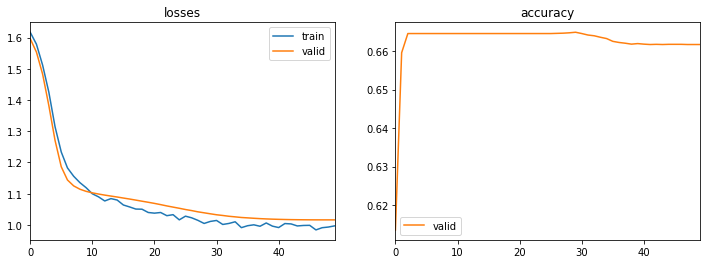

Trying params:                                                                                                         
{'batch_size': 1024, 'conv_dropout': 0.5, 'epochs': 10, 'ks': 3, 'layers': (25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 5, 'time_steps': 90}
TCN                                                                                                                    
 60%|████████████████████████████▏                  | 18/30 [52:34<43:56, 219.74s/trial, best loss: 0.7997812628746033]

epoch,train_loss,valid_loss,accuracy,time
0,1.936850,1.891173,0.137397,00:02
1,1.551257,1.262412,0.664543,00:02
2,1.155338,1.108321,0.660586,00:02
3,1.059204,1.077707,0.654360,00:02
4,1.025219,1.049940,0.648617,00:02
5,1.002782,1.022260,0.646639,00:02
6,0.986454,1.005179,0.646060,00:02
7,0.976239,0.993167,0.646349,00:02
8,0.970783,0.988925,0.646060,00:02
9,0.972282,0.989255,0.645915,00:02


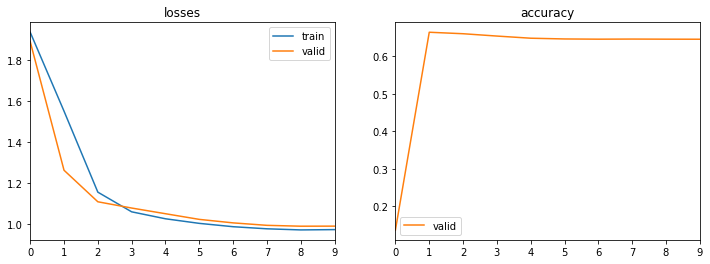

Trying params:                                                                                                         
{'batch_size': 256, 'conv_dropout': 0.5, 'epochs': 100, 'ks': 3, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.1, 'optimizer': <function SGD at 0x000002238948E0D8>, 'patience': 10, 'time_steps': 60}
TCN                                                                                                                    
 63%|█████████████████████████████▊                 | 19/30 [53:28<31:06, 169.73s/trial, best loss: 0.7997812628746033]

epoch,train_loss,valid_loss,accuracy,time
0,1.120646,1.135804,0.664543,00:07
1,1.084508,1.114903,0.664543,00:07
2,1.047063,1.083761,0.664543,00:07
3,1.014727,1.043426,0.664302,00:07
4,0.998379,1.012195,0.648328,00:07
5,0.970852,0.983413,0.644757,00:07
6,0.959267,0.970689,0.644177,00:07
7,0.954056,0.945191,0.648521,00:07
8,0.932552,0.934077,0.653974,00:07
9,0.932774,0.935910,0.653878,00:07


No improvement since epoch 39: early stopping                                                                          
 63%|█████████████████████████████▊                 | 19/30 [59:22<31:06, 169.73s/trial, best loss: 0.7997812628746033]

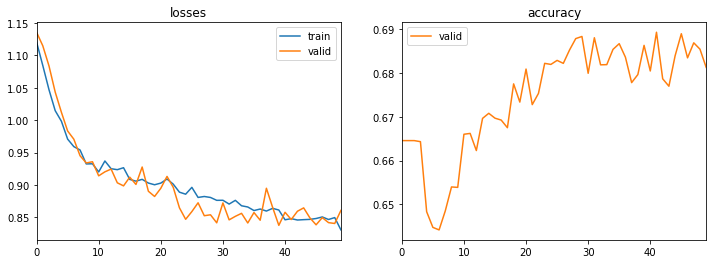

Trying params:                                                                                                         
{'batch_size': 1024, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 10, 'time_steps': 90}
TCN                                                                                                                    
 67%|███████████████████████████████▎               | 20/30 [59:50<39:00, 234.05s/trial, best loss: 0.7997812628746033]

epoch,train_loss,valid_loss,accuracy,time
0,1.797457,1.788061,0.137879,00:02
1,1.771205,1.757520,0.138507,00:02
2,1.735704,1.717074,0.149076,00:02
3,1.680048,1.650417,0.364702,00:02
4,1.574504,1.509633,0.661358,00:02
5,1.368598,1.254297,0.664543,00:02
6,1.190371,1.154906,0.664543,00:02
7,1.132340,1.136276,0.664543,00:02
8,1.097168,1.116041,0.664543,00:02
9,1.069044,1.089621,0.664543,00:02


No improvement since epoch 56: early stopping                                                                          
 67%|██████████████████████████████               | 20/30 [1:02:50<39:00, 234.05s/trial, best loss: 0.7997812628746033]

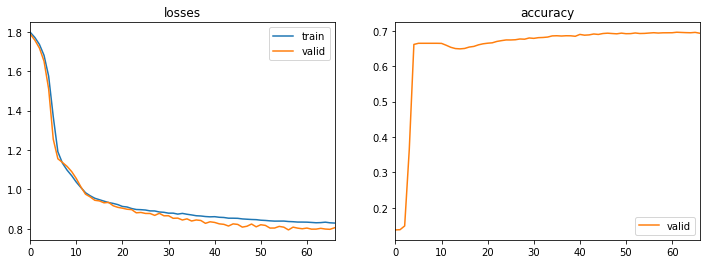

Trying params:                                                                                                         
{'batch_size': 512, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 10, 'time_steps': 90}
TCN                                                                                                                    
 70%|███████████████████████████████▍             | 21/30 [1:03:17<33:55, 226.18s/trial, best loss: 0.7997812628746033]

epoch,train_loss,valid_loss,accuracy,time
0,1.649090,1.623056,0.664543,00:03
1,1.576583,1.547522,0.664543,00:03
2,1.461750,1.422256,0.664543,00:04
3,1.288082,1.234431,0.664543,00:03
4,1.187819,1.152167,0.664543,00:03
5,1.115038,1.105133,0.664543,00:03
6,1.066997,1.069708,0.664543,00:03
7,1.019809,1.028103,0.661599,00:03
8,0.988746,0.983891,0.658076,00:03
9,0.973268,0.961088,0.658607,00:03


No improvement since epoch 56: early stopping                                                                          
 70%|███████████████████████████████▍             | 21/30 [1:07:45<33:55, 226.18s/trial, best loss: 0.7997812628746033]

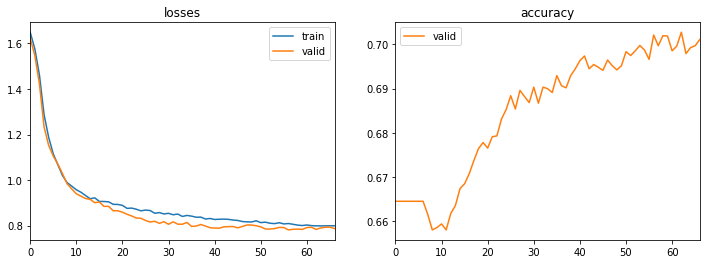

Trying params:                                                                                                         
{'batch_size': 512, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 10, 'time_steps': 90}
TCN                                                                                                                    
 73%|█████████████████████████████████            | 22/30 [1:08:12<32:54, 246.77s/trial, best loss: 0.7871344089508057]

epoch,train_loss,valid_loss,accuracy,time
0,1.688662,1.660319,0.664543,00:03
1,1.624065,1.591674,0.664543,00:03
2,1.530279,1.491007,0.664543,00:03
3,1.377915,1.328847,0.664543,00:03
4,1.247348,1.219319,0.664543,00:03
5,1.119619,1.128624,0.664543,00:03
6,1.066542,1.106101,0.664543,00:03
7,1.038506,1.082939,0.664543,00:03
8,1.009021,1.036815,0.664784,00:03
9,0.973789,0.992002,0.657787,00:03


No improvement since epoch 48: early stopping                                                                          
 73%|█████████████████████████████████            | 22/30 [1:12:08<32:54, 246.77s/trial, best loss: 0.7871344089508057]

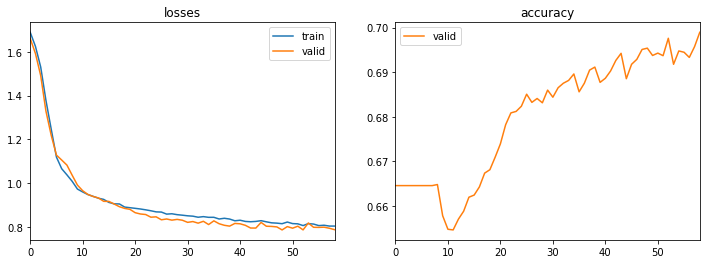

Trying params:                                                                                                         
{'batch_size': 512, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 10, 'time_steps': 90}
TCN                                                                                                                    
 77%|██████████████████████████████████▌          | 23/30 [1:12:37<29:21, 251.71s/trial, best loss: 0.7871344089508057]

epoch,train_loss,valid_loss,accuracy,time
0,1.699133,1.669396,0.658993,00:03
1,1.618633,1.583080,0.664543,00:03
2,1.492487,1.441562,0.664543,00:03
3,1.288777,1.229165,0.664543,00:03
4,1.161736,1.136501,0.664543,00:03
5,1.113616,1.106081,0.664543,00:03
6,1.069893,1.087847,0.664543,00:03
7,1.047351,1.067160,0.664543,00:03
8,1.012965,1.023825,0.662516,00:03
9,0.981201,0.972557,0.656049,00:03


No improvement since epoch 58: early stopping                                                                          
 77%|██████████████████████████████████▌          | 23/30 [1:17:13<29:21, 251.71s/trial, best loss: 0.7871344089508057]

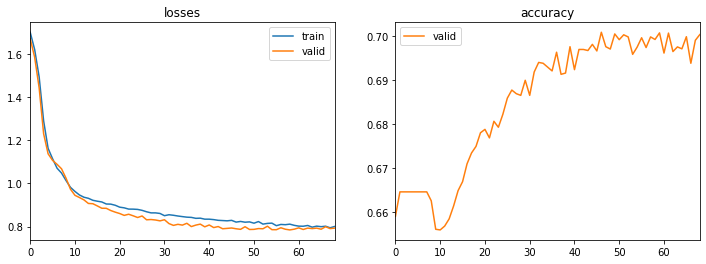

Trying params:                                                                                                         
{'batch_size': 512, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 10, 'time_steps': 90}
TCN                                                                                                                    
 80%|████████████████████████████████████         | 24/30 [1:17:42<26:46, 267.80s/trial, best loss: 0.7871344089508057]

epoch,train_loss,valid_loss,accuracy,time
0,1.678464,1.667297,0.664543,00:03
1,1.617521,1.603172,0.664543,00:03
2,1.498642,1.470823,0.664543,00:03
3,1.258644,1.213599,0.664543,00:03
4,1.130594,1.128288,0.664543,00:03
5,1.089614,1.105879,0.664543,00:03
6,1.058436,1.088567,0.664543,00:03
7,1.027722,1.055815,0.664543,00:03
8,1.000811,1.009634,0.664543,00:04
9,0.978973,0.970956,0.659572,00:03


No improvement since epoch 55: early stopping                                                                          
 80%|████████████████████████████████████         | 24/30 [1:22:07<26:46, 267.80s/trial, best loss: 0.7871344089508057]

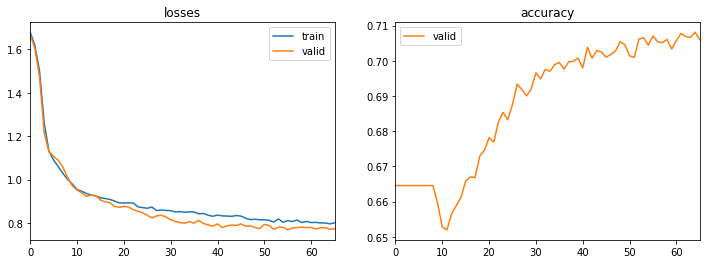

Trying params:                                                                                                         
{'batch_size': 512, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 10, 'time_steps': 90}
TCN                                                                                                                    
 83%|█████████████████████████████████████▌       | 25/30 [1:22:35<22:57, 275.55s/trial, best loss: 0.7729510068893433]

epoch,train_loss,valid_loss,accuracy,time
0,1.718585,1.691710,0.155881,00:03
1,1.623548,1.588719,0.664495,00:03
2,1.467872,1.411355,0.664543,00:03
3,1.275006,1.222632,0.664543,00:03
4,1.172353,1.155355,0.664543,00:03
5,1.127897,1.121578,0.664543,00:03
6,1.079004,1.084943,0.664543,00:03
7,1.035888,1.042886,0.664350,00:03
8,0.997340,0.983417,0.660586,00:03
9,0.973321,0.944846,0.658318,00:03


No improvement since epoch 43: early stopping                                                                          
 83%|█████████████████████████████████████▌       | 25/30 [1:26:10<22:57, 275.55s/trial, best loss: 0.7729510068893433]

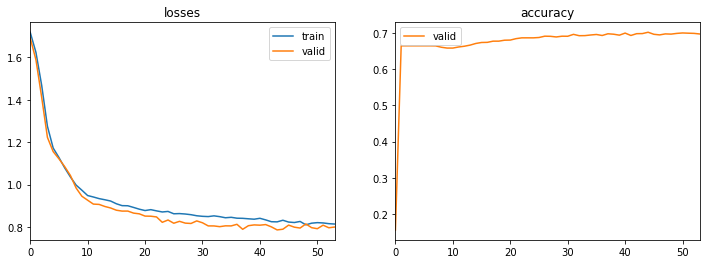

Trying params:                                                                                                         
{'batch_size': 512, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.001, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 10, 'time_steps': 90}
TCN                                                                                                                    
 87%|███████████████████████████████████████      | 26/30 [1:26:37<17:42, 265.72s/trial, best loss: 0.7729510068893433]

epoch,train_loss,valid_loss,accuracy,time
0,1.243688,1.141253,0.664543,00:03
1,1.060858,1.070908,0.664543,00:03
2,1.003713,1.002288,0.657304,00:03
3,0.963452,0.958544,0.647363,00:03
4,0.942945,0.937997,0.653009,00:03
5,0.924603,0.914343,0.658704,00:03
6,0.897046,0.876252,0.664109,00:03
7,0.896768,0.867254,0.670672,00:03
8,0.883839,0.864039,0.676077,00:03
9,0.872891,0.855982,0.682158,00:03


No improvement since epoch 22: early stopping                                                                          
 87%|███████████████████████████████████████      | 26/30 [1:28:49<17:42, 265.72s/trial, best loss: 0.7729510068893433]

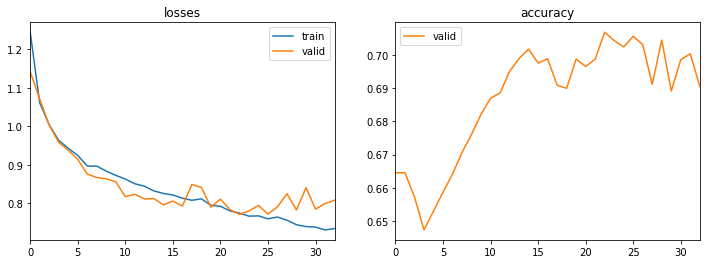

Trying params:                                                                                                         
{'batch_size': 512, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 10, 'time_steps': 90}
TCN                                                                                                                    
 90%|████████████████████████████████████████▌    | 27/30 [1:29:17<11:41, 233.76s/trial, best loss: 0.7729510068893433]

epoch,train_loss,valid_loss,accuracy,time
0,1.826716,1.817761,0.080884,00:03
1,1.745978,1.733994,0.097389,00:03
2,1.608377,1.583941,0.627383,00:03
3,1.367748,1.329817,0.664543,00:03
4,1.202469,1.182690,0.664543,00:03
5,1.105718,1.117326,0.664543,00:03
6,1.057181,1.103539,0.664543,00:03
7,1.036229,1.076716,0.663385,00:03
8,1.001019,1.029698,0.660152,00:03
9,0.970030,0.982701,0.654505,00:03


No improvement since epoch 45: early stopping                                                                          
 90%|████████████████████████████████████████▌    | 27/30 [1:33:00<11:41, 233.76s/trial, best loss: 0.7729510068893433]

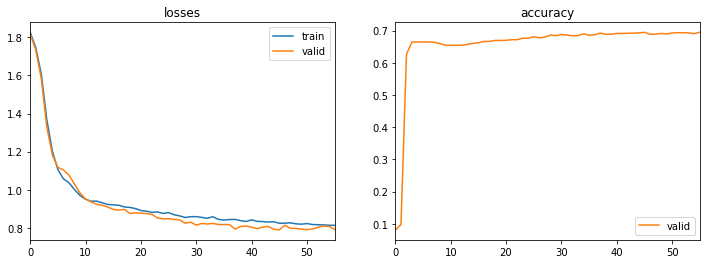

Trying params:                                                                                                         
{'batch_size': 512, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 10, 'time_steps': 30}
TCN                                                                                                                    
 93%|██████████████████████████████████████████   | 28/30 [1:33:29<07:58, 239.03s/trial, best loss: 0.7729510068893433]

epoch,train_loss,valid_loss,accuracy,time
0,1.738407,1.734272,0.137879,00:04
1,1.699851,1.696000,0.137879,00:04
2,1.647031,1.641222,0.142223,00:04
3,1.556907,1.542898,0.392114,00:04
4,1.388025,1.360460,0.664543,00:04
5,1.192948,1.181235,0.664543,00:04
6,1.120891,1.129895,0.664543,00:04
7,1.082204,1.104859,0.664543,00:04
8,1.046000,1.074337,0.664543,00:04
9,1.024707,1.040496,0.663481,00:04


No improvement since epoch 38: early stopping                                                                          
 93%|██████████████████████████████████████████   | 28/30 [1:37:26<07:58, 239.03s/trial, best loss: 0.7729510068893433]

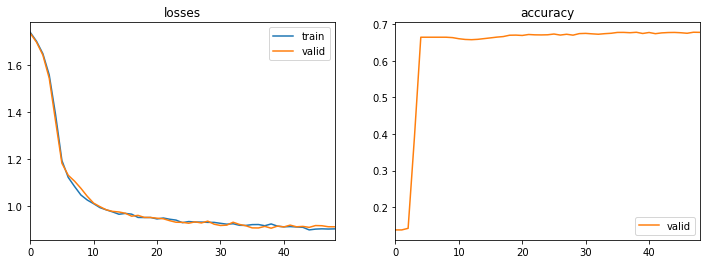

Trying params:                                                                                                         
{'batch_size': 512, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 10, 'time_steps': 90}
TCN                                                                                                                    
 97%|███████████████████████████████████████████▌ | 29/30 [1:37:53<04:06, 246.98s/trial, best loss: 0.7729510068893433]

epoch,train_loss,valid_loss,accuracy,time
0,1.600645,1.600312,0.664543,00:03
1,1.494372,1.489554,0.664543,00:03
2,1.333898,1.310870,0.664543,00:03
3,1.191058,1.175696,0.664543,00:03
4,1.122132,1.121435,0.664543,00:03
5,1.076704,1.100505,0.664543,00:03
6,1.045048,1.081987,0.664543,00:03
7,1.017019,1.046787,0.659428,00:03
8,0.989345,1.001607,0.653347,00:03
9,0.960159,0.972723,0.653733,00:03


No improvement since epoch 62: early stopping                                                                          
 97%|███████████████████████████████████████████▌ | 29/30 [1:42:39<04:06, 246.98s/trial, best loss: 0.7729510068893433]

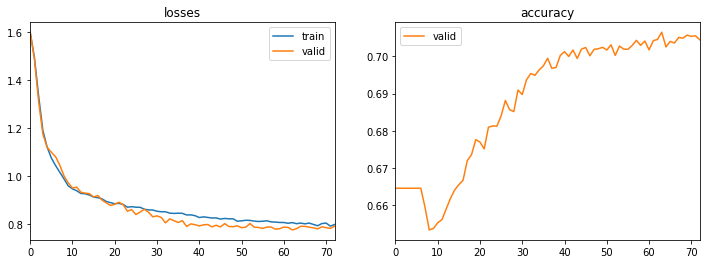

100%|█████████████████████████████████████████████| 30/30 [1:42:40<00:00, 205.34s/trial, best loss: 0.7729510068893433]


In [34]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,  # test trials
    trials=trials)

In [35]:
print(best)

{'bs': 1, 'conv_dropout': 2, 'epochs': 2, 'ks': 0, 'layers': 2, 'lr': 3, 'optimizer': 0, 'patience': 1, 'ts': 2}


In [36]:
from hyperopt import space_eval

In [37]:
print("Best parameters:")
print(space_eval(search_space, best))

Best parameters:
{'batch_size': 512, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 10, 'time_steps': 90}


In [38]:
best_parameters = space_eval(search_space, best)

In [39]:
def build_model(params):
    # clear memory 
    gc.collect()
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    # Create data loader
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
    # set num_workers for memory bottleneck
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
    # Create model
    arch = TCN
    k = {
        'layers': params['layers'],
        'ks': params['ks'],
        'conv_dropout': params['conv_dropout']
    }
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    # Training the model
    learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
    start = time.time()
    learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                        cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
    learn.plot_metrics()
    elapsed = time.time() - start
    
    # delete tmp variables
    del dls
    del model
    return learn

Trying params: {'batch_size': 512, 'conv_dropout': 0.2, 'epochs': 100, 'ks': 7, 'layers': (25, 25, 25, 25), 'lr': 0.0001, 'optimizer': <function Adam at 0x000002238948E438>, 'patience': 10, 'time_steps': 90}
TCN


epoch,train_loss,valid_loss,accuracy,time
0,1.862798,1.854511,0.015105,00:03
1,1.794666,1.783254,0.105835,00:03
2,1.672022,1.649564,0.654409,00:03
3,1.415512,1.374441,0.664543,00:03
4,1.178264,1.164685,0.664543,00:03
5,1.111629,1.125865,0.664543,00:03
6,1.070092,1.108100,0.664543,00:03
7,1.046708,1.080079,0.664543,00:03
8,1.018846,1.033656,0.661744,00:03
9,0.981000,0.993867,0.653202,00:03


No improvement since epoch 60: early stopping


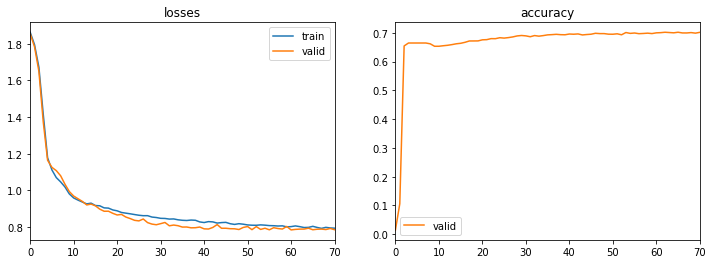

In [40]:
learn = build_model(best_parameters)

In [41]:
dls = learn.dls
valid_dl = dls.valid

In [42]:
time_steps = best_parameters["time_steps"]
X_test_tmp = X_test[:, :, -time_steps:]

In [43]:
test_ds = valid_dl.dataset.add_test(X_test_tmp, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

102430


In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[6.1896e-01, 2.5234e-01, 9.8221e-02, 2.7708e-02, 2.6781e-03, 9.9139e-05],
         [8.4441e-01, 9.3487e-02, 5.3891e-02, 7.6461e-03, 5.0485e-04, 5.7143e-05],
         [9.7436e-01, 2.3614e-02, 1.7551e-03, 2.6921e-04, 4.4395e-06, 2.2584e-08],
         ...,
         [9.8691e-01, 1.1022e-02, 1.5665e-03, 4.7231e-04, 2.9882e-05, 1.0955e-06],
         [9.9615e-01, 3.4574e-03, 3.3188e-04, 6.3170e-05, 1.5827e-06, 2.9265e-08],
         [9.4211e-01, 4.9118e-02, 6.6841e-03, 2.0014e-03, 8.8487e-05, 1.1517e-06]]),
 TensorCategory([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [45]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'f1 score: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.703856
f1 score:   0.693425


Save the true and predicted results:

In [46]:
y_test_true = test_targets.numpy()
y_test_pred = test_preds.numpy()

In [47]:
np.save('y_true_TCN', y_test_true)
np.save('y_pred_TCN', y_test_pred)